# Redes Neuronales
Dentro de este Jupyter Notebook, aplicamos redes neuronales para intentar crear modelos de clasificación y regresión sobre el dataset de Olist. Dentro de ellos:

- Modelos de Regresion
    - Prediccion de Review Score, a pesar de ser mas un problema de clasificacion decidimos incluirlo dentro de regresiones para tener un analisis comparativo

- Modelos de Clasificacion
    - Prediccion de Review Score
    - Prediccion de Delivery Delayed, para pedidos atrasados
    - Prediccion de Satisfaccion del Cliente, 4+ en Review Score = Satisfecho. No satisfecho de lo contrario

Antes de empezar, podemos cargar el Dataset y limpiarlos ligeramente para evitar data leakage

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV
# Removed explicit import of StandardScaler here
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score # Import evaluation metrics


df = pd.read_csv('dataset/cleaned_orders.csv')
df = df.dropna()

dfreview = df.copy()
dfdays = df.copy()
dfdelayed = df.copy()

dfdays.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dfdelayed.drop(columns=['delivery_days', 'delivery_delta', 'review_score'], inplace=True)

review_train, review_test = train_test_split(
    dfreview,
    test_size=0.3,
    stratify=dfreview['review_score'],
    random_state=42
)

days_train, days_test = train_test_split(
    dfdays,
    test_size=0.3,
    random_state=42
)

delayed_train, delayed_test = train_test_split(
    dfdelayed,
    test_size=0.3,
    random_state=42
)

Y_review_train = review_train['review_score']
X_review_train = review_train.drop(columns=['review_score'])
Y_review_test = review_test['review_score']
X_review_test = review_test.drop(columns=['review_score'])

Y_days_train = days_train['delivery_days']
X_days_train = days_train.drop(columns=['delivery_days'])
Y_days_test = days_test['delivery_days']
X_days_test = days_test.drop(columns=['delivery_days'])

Y_delayed_train = delayed_train['delivery_delayed']
X_delayed_train = delayed_train.drop(columns=['delivery_delayed'])
Y_delayed_test = delayed_test['delivery_delayed']
X_delayed_test = delayed_test.drop(columns=['delivery_delayed'])

Y_satisfaction_train = (Y_review_train >= 4).astype(int)
Y_satisfaction_test = (Y_review_test >= 4).astype(int)
X_satisfaction_train = X_review_train.copy()
X_satisfaction_test = X_review_test.copy()

numeric_cols = X_satisfaction_train.select_dtypes(include=np.number).columns.tolist()

binary_cols = []
for col in X_satisfaction_train.columns:
    if X_satisfaction_train[col].nunique() <= 2:
        binary_cols.append(col)

true_numeric_cols = [col for col in numeric_cols if col not in binary_cols]

categorical_cols = X_satisfaction_train.select_dtypes(include='object').columns.tolist()

print("True Numeric columns:", true_numeric_cols)
print("Binary/Potential One-Hot columns (<= 2 distinct values):", binary_cols)
print("Categorical columns (if any):", categorical_cols)

True Numeric columns: ['estimated_delivery_days', 'delivery_days', 'delivery_delta', 'avg_product_price', 'total_order_price', 'item_count', 'order_freight_value', 'freight_to_price', 'shipping_distance_km', 'payment_installments', 'product_size_factor']
Binary/Potential One-Hot columns (<= 2 distinct values): ['delivery_delayed', 'different_state', 'seller_state_AM', 'seller_state_BA', 'seller_state_CE', 'seller_state_DF', 'seller_state_ES', 'seller_state_GO', 'seller_state_MA', 'seller_state_MG', 'seller_state_MS', 'seller_state_MT', 'seller_state_PA', 'seller_state_PB', 'seller_state_PE', 'seller_state_PI', 'seller_state_PR', 'seller_state_RJ', 'seller_state_RN', 'seller_state_RO', 'seller_state_RS', 'seller_state_SC', 'seller_state_SE', 'seller_state_SP', 'customer_state_AC', 'customer_state_AL', 'customer_state_AM', 'customer_state_AP', 'customer_state_BA', 'customer_state_CE', 'customer_state_DF', 'customer_state_ES', 'customer_state_GO', 'customer_state_MA', 'customer_state_MG',

Podemos definir una funcion de utilidad para distinguir columnas numericas que necesitamos escalar, a diferencia de las one-hot-encoded.

In [36]:
def get_column_types(dataframe):

    numeric_cols = dataframe.select_dtypes(include=np.number).columns.tolist()

    binary_cols = []
    for col in dataframe.columns:
        try:
            if dataframe[col].nunique() <= 2:
                binary_cols.append(col)
        except TypeError:
            pass

    true_numeric_cols = [col for col in numeric_cols if col not in binary_cols]

    categorical_cols = dataframe.select_dtypes(include='object').columns.tolist()

    return true_numeric_cols, binary_cols, categorical_cols

In [60]:
def plot_regression_results(Y_test, Y_pred, target_column_name="Target", model_name="Model"):
    residuals = Y_test - Y_pred

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].scatter(Y_test, Y_pred,
                    alpha=0.025,
                    s=10)
    min_val = min(Y_test.min(), Y_pred.min())
    max_val = max(Y_test.max(), Y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val],
             color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel(f"Valores Reales ({target_column_name})", fontsize=12)
    axes[0].set_ylabel(f"Predicciones ({target_column_name})", fontsize=12)
    axes[0].set_title(f"Valores Reales vs Predicciones\n({model_name})", fontsize=14)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    axes[1].scatter(Y_pred, residuals,
                    alpha=0.025,
                    s=10)
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel(f"Valores Predichos ({target_column_name})", fontsize=12)
    axes[1].set_ylabel("Residuos", fontsize=12)
    axes[1].set_title(f"Residuos vs. Predichos\n({model_name})", fontsize=14)
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def print_regression_metrics(Y_test, Y_pred, model_name="Model"):
    mse = mean_squared_error(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    rmse = np.sqrt(mse)

    print(f"\n--- Evaluación de {model_name} ---")
    print(f"Mean Squared Error (MSE):     {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE):    {mae:.6f}")
    print(f"R-squared (R²):               {r2:.6f}")
    print("-" * (len(f"--- Evaluación del {model_name} ---")))

# Clasificación

## Review Score

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [45]:
true_numeric_cols_review, binary_cols_review, categorical_cols_review = get_column_types(X_review_train)

preprocessing_steps_review = []

if true_numeric_cols_review:
    preprocessing_steps_review.append(('standard_scaler', StandardScaler(), true_numeric_cols_review))

preprocessor_review = ColumnTransformer(
    preprocessing_steps_review,
    remainder='passthrough'
)

model_review = MLPClassifier(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_review_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_review),
    ('model', model_review)
])

print(pipeline_review_manual)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['estimated_delivery_days',
                                                   'delivery_days',
                                                   'delivery_delta',
                                                   'avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   

### Predicciones

Teniendo ya definido el pipeline, podemos empezar a realizar predicciones con el modelo. Para esto, vamos a empezar con un modelo bastante simple.


Accuracy on Test Set: 0.6211


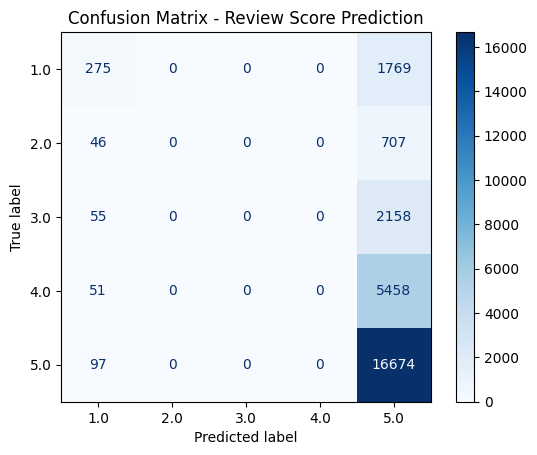


Classification Report:
              precision    recall  f1-score   support

         1.0       0.52      0.13      0.21      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.00      0.00      0.00      2213
         4.0       0.00      0.00      0.00      5509
         5.0       0.62      0.99      0.77     16771

    accuracy                           0.62     27290
   macro avg       0.23      0.23      0.20     27290
weighted avg       0.42      0.62      0.49     27290



/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [46]:
pipeline_review_manual.fit(X_review_train, Y_review_train)

y_pred_review = pipeline_review_manual.predict(X_review_test)

accuracy = accuracy_score(Y_review_test, y_pred_review)
print(f"\nAccuracy on Test Set: {accuracy:.4f}")

cm = confusion_matrix(Y_review_test, y_pred_review)

classes = sorted(Y_review_test.unique())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Review Score Prediction')
plt.show()

print("\nClassification Report:")
print(classification_report(Y_review_test, y_pred_review))

Dentro de la matriz de confusión podemos observar que todas las predicciones son de valores de 0 o de 5, esto nos puede indicar que posiblemente nuestro modelo es demasiado simple. Potencialmente encontramos mejores resultados explorando por medio de un Gridsearch.

### Gridsearch y Cross Validation

Ahora, vamos a realizar un Gridsearch con validación cruzada para explorar la arquitectura óptima de nuestro modelo según el F1_macro.

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M


Confusion Matrix (Best Model):


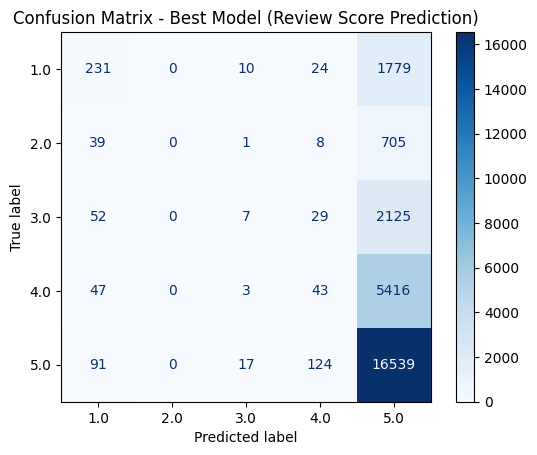


Classification Report (Best Model):
              precision    recall  f1-score   support

         1.0       0.50      0.11      0.18      2044
         2.0       0.00      0.00      0.00       753
         3.0       0.18      0.00      0.01      2213
         4.0       0.19      0.01      0.01      5509
         5.0       0.62      0.99      0.76     16771

    accuracy                           0.62     27290
   macro avg       0.30      0.22      0.19     27290
weighted avg       0.47      0.62      0.49     27290

Best parameters found by Grid Search: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (20, 10, 5), 'model__learning_rate_init': 0.01, 'model__max_iter': 200}


/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [48]:
param_grid = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search = GridSearchCV(
    pipeline_review_manual,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_review_train, Y_review_train)

best_pipeline = grid_search.best_estimator_

y_pred_best = best_pipeline.predict(X_review_test)

print("\nConfusion Matrix (Best Model):")
cm_best = confusion_matrix(Y_review_test, y_pred_best)
classes = sorted(Y_review_test.unique())
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=classes)
disp_best.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model (Review Score Prediction)')
plt.show()

print("\nClassification Report (Best Model):")
print(classification_report(Y_review_test, y_pred_best))

print("Best parameters found by Grid Search:", grid_search.best_params_)

Los resultados son bastante similares al inciso anterior, y se comparan a los resultados utilizando modelos de clasificación como Random Forest. El modelo sigue prediciendo bastante seguido los valores más altos, sacrificando la precisión en algunos de los valores intermedios. Además, no parece encontrar una distinción clara entre valores adyacentes. Vale la pena recalcar que en cuánto a arquitectura, el modelo elegido fue más complejo que el inicial. Esto nos sugiere que podríamos explorar arquitecturas aún más complejas

### Conclusiones

- Este clasificador utilizando redes neuronales tuvo resultados similares a las regresiones aplicadas, dónde los valores "macro" son sumamente bajos y los "weighed" tienden a ser más altos.
- En este caso, las ganancias en cuánto a rendimiento del modelo no fueron significativas. Si hubo una mejora, pero los resultados fueron similares.
- Una arquitectura más compleja no necesariamente significa mejores resultados.

## Satisfacción del Cliente

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [49]:
true_numeric_cols_satisfaction, binary_cols_satisfaction, categorical_cols_satisfaction = get_column_types(X_satisfaction_train)

preprocessing_steps_satisfaction = []

if true_numeric_cols_satisfaction:
    preprocessing_steps_satisfaction.append(('standard_scaler', StandardScaler(), true_numeric_cols_satisfaction))

preprocessor_satisfaction = ColumnTransformer(
    preprocessing_steps_satisfaction,
    remainder='passthrough'
)

model_satisfaction = MLPClassifier(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_satisfaction_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_satisfaction),
    ('model', model_satisfaction)
])

print(pipeline_satisfaction_manual)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['estimated_delivery_days',
                                                   'delivery_days',
                                                   'delivery_delta',
                                                   'avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   

### Predicciones

Ahora podemos empezar a hacer predicciones con un modelo básico

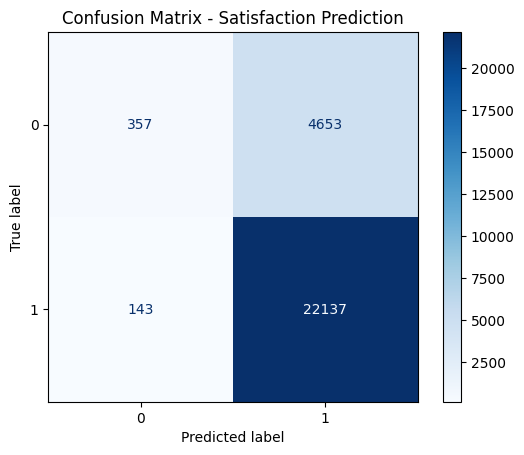


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.07      0.13      5010
           1       0.83      0.99      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.77      0.53      0.52     27290
weighted avg       0.81      0.82      0.76     27290



In [50]:
pipeline_satisfaction_manual.fit(X_satisfaction_train, Y_satisfaction_train)

y_pred_satisfaction = pipeline_satisfaction_manual.predict(X_satisfaction_test)

cm_satisfaction = confusion_matrix(Y_satisfaction_test, y_pred_satisfaction)

classes_satisfaction = sorted(Y_satisfaction_test.unique())

disp_satisfaction = ConfusionMatrixDisplay(confusion_matrix=cm_satisfaction, display_labels=classes_satisfaction)
disp_satisfaction.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Satisfaction Prediction')
plt.show()

print("\nClassification Report:")
print(classification_report(Y_satisfaction_test, y_pred_satisfaction))

Esta red neuronal tiene resultados comparables al mejor modelo de clasificación, a pesar de tener una precisión más alta en valores de 1, sigue teniendo una precisión de 0.71 para valores de clientes no satisfcehos.

### Gridsearch y Cross-Validation

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M


Confusion Matrix (Best Model):


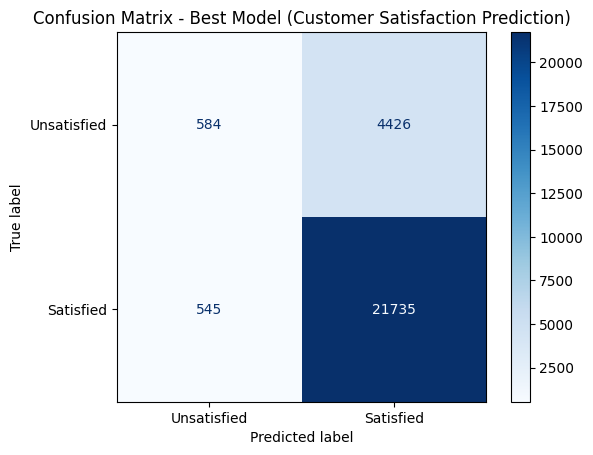


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.52      0.12      0.19      5010
           1       0.83      0.98      0.90     22280

    accuracy                           0.82     27290
   macro avg       0.67      0.55      0.54     27290
weighted avg       0.77      0.82      0.77     27290

Best parameters found by Grid Search: {'model__alpha': 0.001, 'model__hidden_layer_sizes': (20, 10, 5), 'model__learning_rate_init': 0.001, 'model__max_iter': 500}


In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search = GridSearchCV(
    pipeline_satisfaction_manual,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_satisfaction_train, Y_satisfaction_train)

best_pipeline = grid_search.best_estimator_

y_pred_best = best_pipeline.predict(X_satisfaction_test)

print("\nConfusion Matrix (Best Model):")
cm_best = confusion_matrix(Y_satisfaction_test, y_pred_best)
classes = ['Unsatisfied', 'Satisfied']
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=classes)
disp_best.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model (Customer Satisfaction Prediction)')
plt.show()

print("\nClassification Report (Best Model):")
print(classification_report(Y_satisfaction_test, y_pred_best))
print("Best parameters found by Grid Search:", grid_search.best_params_)


Este modelo en comparación al anterior tiene un recall y un f1 considerablemente mayor para clientes no satisfechos en comparación al anterior. Además, la arquitectura de este modelo es más compleja en comparación al inicial. Esto nos lleva a concluir que un modelo más complejo puede predecir variables menos frecuentes con mayor exactitud, y vale la pena seguir explorando arquitecturas más complejas.

### Conclusiones

- La clasificación utilizando redes neuronales tuvo las mejores métricas en general, superando los demás modelos de clasificación
- Los modelos más complejos pueden adaptarse mejor a distribuciones disparejas
- Utilizar Gridsearch con validación cruzada es una estrategia viable al implementar redes neuronales

## Delivery Delayed

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [53]:
true_numeric_cols_delayed, binary_cols_delayed, categorical_cols_delayed = get_column_types(X_delayed_train)

preprocessing_steps_delayed = []

if true_numeric_cols_delayed:
    preprocessing_steps_delayed.append(('standard_scaler', StandardScaler(), true_numeric_cols_delayed))

preprocessor_delayed = ColumnTransformer(
    preprocessing_steps_delayed,
    remainder='passthrough'
)

model_delayed = MLPClassifier(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_delayed_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_delayed),
    ('model', model_delayed)
])

print(pipeline_delayed_manual)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['estimated_delivery_days',
                                                   'avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   'product_size_factor'])])),
                ('model',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=(5, 3),
      

### Predicciones


Accuracy on Test Set: 0.9632


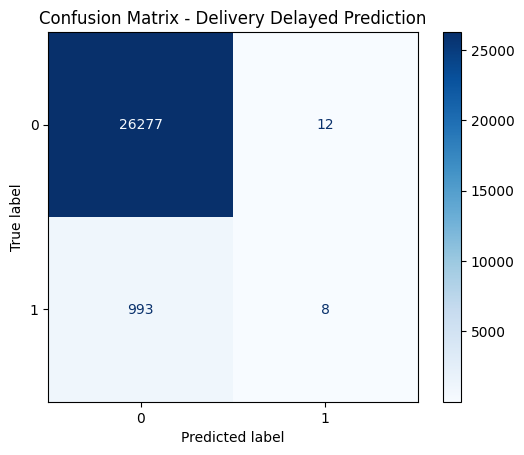


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.40      0.01      0.02      1001

    accuracy                           0.96     27290
   macro avg       0.68      0.50      0.50     27290
weighted avg       0.94      0.96      0.95     27290



In [55]:
pipeline_delayed_manual.fit(X_delayed_train, Y_delayed_train)

y_pred_delayed = pipeline_delayed_manual.predict(X_delayed_test)

accuracy_delayed = accuracy_score(Y_delayed_test, y_pred_delayed)
print(f"\nAccuracy on Test Set: {accuracy_delayed:.4f}")

cm_delayed = confusion_matrix(Y_delayed_test, y_pred_delayed)

classes_delayed = sorted(Y_delayed_test.unique())

disp_delayed = ConfusionMatrixDisplay(confusion_matrix=cm_delayed, display_labels=classes_delayed)
disp_delayed.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Delivery Delayed Prediction')
plt.show()

print("\nClassification Report:")
print(classification_report(Y_delayed_test, y_pred_delayed))

Este modelo parece tener números bastante prometedores, ya que los promedios weighed son bastante altos. Sin embargo, esto puede no contar toda la historia. Ya que para los pedidos atrasados el recall y el puntaje f1 son sumamente bajos. Este modelo generaliza mucho, y esperamos que, similar al modelo anterior, al explorar diferentes arquitecturas más complejas logremos tener mejores resultados para estos parámetros con menor representación.

### Gridsearch y Cross Validation

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M


Confusion Matrix (Best Model):


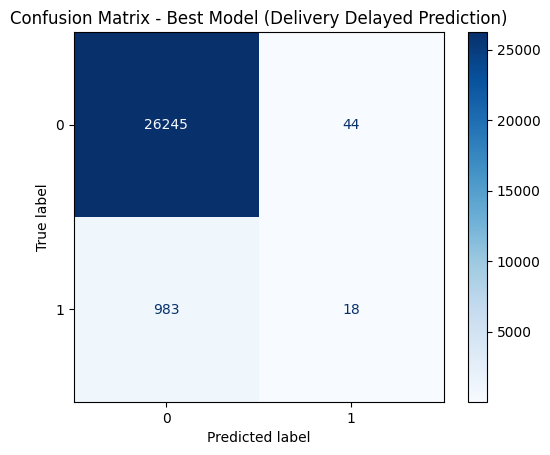


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     26289
           1       0.29      0.02      0.03      1001

    accuracy                           0.96     27290
   macro avg       0.63      0.51      0.51     27290
weighted avg       0.94      0.96      0.95     27290

Best parameters found by Grid Search: {'model__alpha': 0.0001, 'model__hidden_layer_sizes': (10, 5), 'model__learning_rate_init': 0.01, 'model__max_iter': 200}


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

param_grid = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search = GridSearchCV(
    pipeline_delayed_manual,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_delayed_train, Y_delayed_train)

best_pipeline = grid_search.best_estimator_

y_pred_best = best_pipeline.predict(X_delayed_test)

print("\nConfusion Matrix (Best Model):")
cm_best = confusion_matrix(Y_delayed_test, y_pred_best)
classes = sorted(Y_delayed_test.unique())
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=classes)
disp_best.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best Model (Delivery Delayed Prediction)')
plt.show()

print("\nClassification Report (Best Model):")
print(classification_report(Y_delayed_test, y_pred_best))

print("Best parameters found by Grid Search:", grid_search.best_params_)

Este modelo tuvo ligeras mejoras sobre el anterior, al explorar una arquitectura más compleja y diferentes parámetros utilizando validación cruzada logramos tener mejores predicciones para deliveries atrasados. En este caso, el recall fue mayor para los pedidos atrasados. Sin embargo, los resultados siguen sin ser muy prometedores y siguen estando al mismo nivel que algunos modelos de clasificación.

### Conclusiones

- El modelo presenta dificultades similares a los demás modelos de clasificación, dónde los datos con poca representación son difíciles de predecir
- Se pueden seguir explorando arquitecturas más complejas y parámetros más variados, ya que por limitaciones de cómputo llegamos al límite con altos tiempos de ejecución
- La complejidad del modelo y el tiempo de cómputo no se relacionan directamente, ya que el trabajo fue muy tardado y las ganancias fueron pocas. Se debe de buscar un balance entre estas variables.

# Regresión

### Pipeline
Para el pipeline de este modelo, necesitamos utilizar un StandardScaler para escalar los datos numéricos. Para esto, utilizamos una función previamente definida para obtener las respectivas columnas, aplicamos el scaler en las columnas obtenidas y para el resto configuramos un passthrough.

In [58]:
from sklearn.neural_network import MLPRegressor 
true_numeric_cols_days, binary_cols_days, categorical_cols_days = get_column_types(X_days_train)

preprocessing_steps_days = []

if true_numeric_cols_days:
    preprocessing_steps_days.append(('standard_scaler', StandardScaler(), true_numeric_cols_days))

preprocessor_days = ColumnTransformer(
    preprocessing_steps_days,
    remainder='passthrough'
)

model_days = MLPRegressor(activation="tanh", verbose=False, hidden_layer_sizes=(5, 3), random_state=42)

pipeline_days_manual = Pipeline(steps=[
    ('preprocessor', preprocessor_days),
    ('model', model_days)
])

print(pipeline_days_manual)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standard_scaler',
                                                  StandardScaler(),
                                                  ['avg_product_price',
                                                   'total_order_price',
                                                   'item_count',
                                                   'order_freight_value',
                                                   'freight_to_price',
                                                   'shipping_distance_km',
                                                   'payment_installments',
                                                   'product_size_factor'])])),
                ('model',
                 MLPRegressor(activation='tanh', hidden_layer_sizes=(5, 3),
                              random_state=42))])


### Predicciones

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


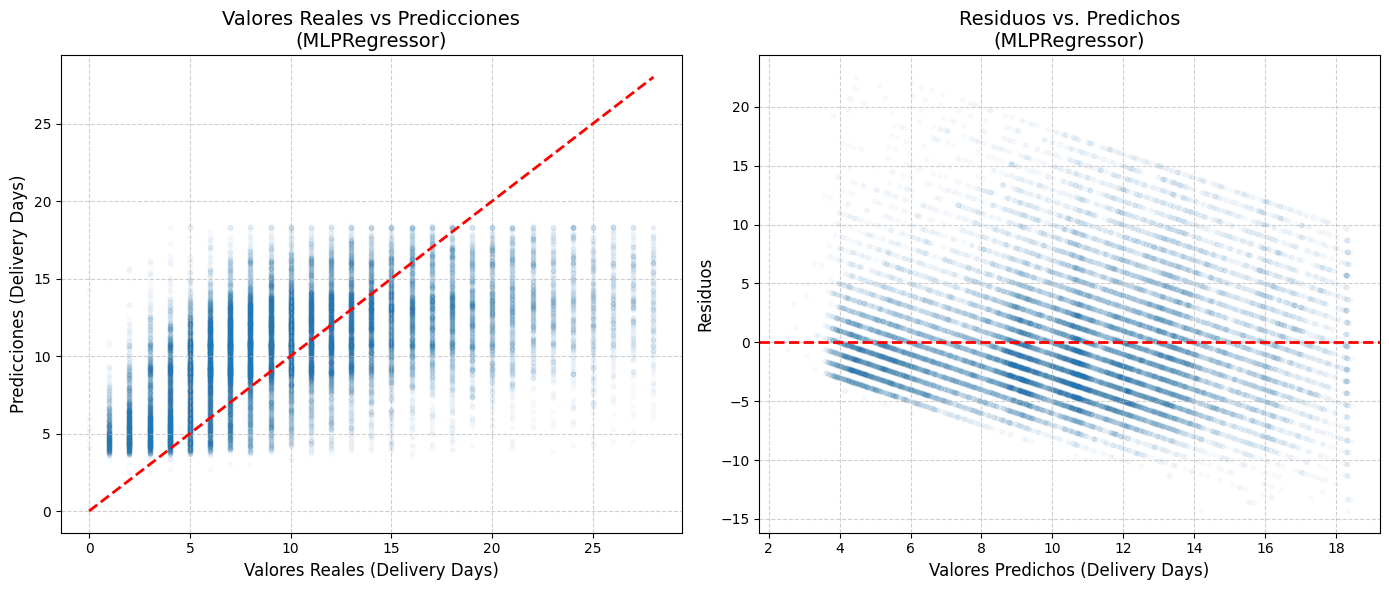


--- Evaluación de MLPRegressor ---
Mean Squared Error (MSE):     25.147722
Root Mean Squared Error (RMSE): 5.014750
Mean Absolute Error (MAE):    3.882067
R-squared (R²):               0.311546
-----------------------------------


In [61]:
pipeline_days_manual.fit(X_days_train, Y_days_train)
y_pred_days = pipeline_days_manual.predict(X_days_test)

plot_regression_results(Y_days_test, y_pred_days, target_column_name="Delivery Days", model_name="MLPRegressor")

print_regression_metrics(Y_days_test, y_pred_days, model_name="MLPRegressor")

Este modelo tiene resultados prometedores, sus métricas son similares al modelo con mejor desempeño que fue Random Forest. Además, parece captar un trend inicial de manera correcta pero predecir de manera incorrecta valores menos frecuentes. En incisos anteriores, habíamos encontrado una mejora en este aspecto al optar por una arquitectura más compleja e implementar validación cruzada. Adicionalmente, según la gráfica de residuos, parece captar las tendencias generales bastante bien. Teniendo los sectores más concentrados cercanos a la línea de 0. Sin embargo, todavía existen secciones más transparentes dónde se pueden observar las imperfecciones del modelo.

### Gridsearch y Cross Validation

/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/Tono/Documents/mineria/proyecto3_Mineria/.venv/lib64/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: M

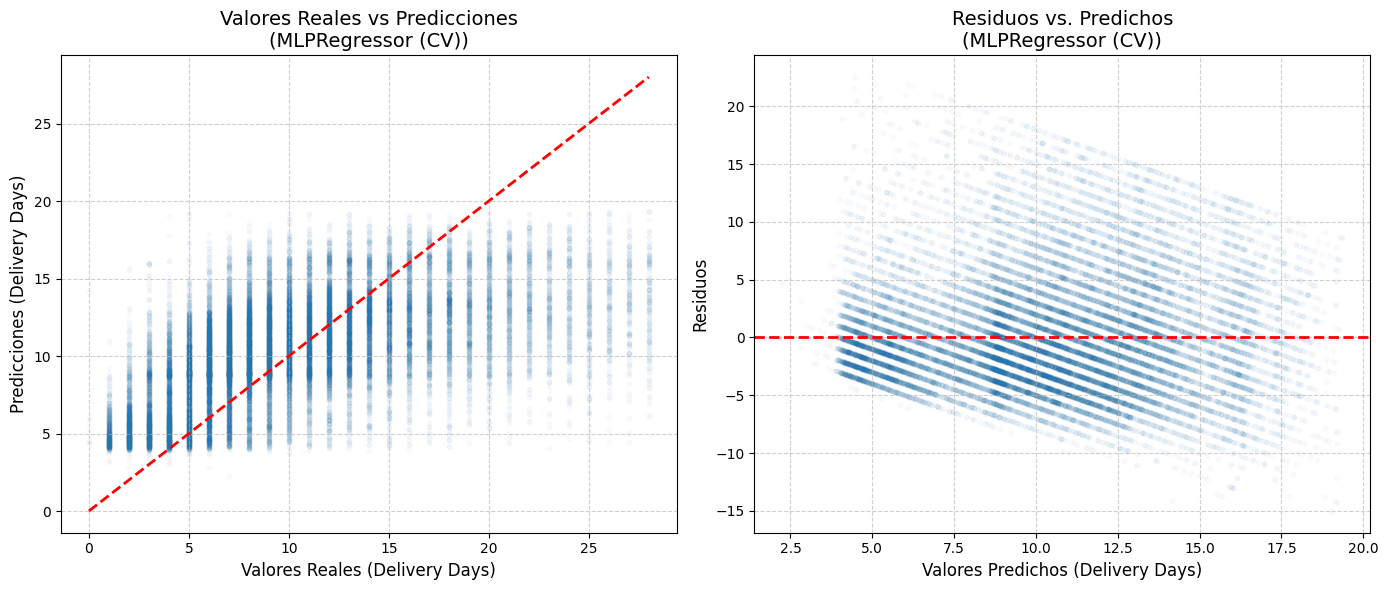


--- Evaluación de MLPRegressor (CV) ---
Mean Squared Error (MSE):     25.107008
Root Mean Squared Error (RMSE): 5.010689
Mean Absolute Error (MAE):    3.854128
R-squared (R²):               0.312661
----------------------------------------

Best parameters found by GridSearchCV for Delivery Days:
{'model__alpha': 0.01, 'model__hidden_layer_sizes': (10, 5), 'model__learning_rate_init': 0.001, 'model__max_iter': 200}


In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor


param_grid_days = {
    'model__hidden_layer_sizes': [(5, 3), (10,), (10, 5), (20, 10, 5)],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [200, 500, 1000]
}

grid_search_days = GridSearchCV(
    pipeline_days_manual,
    param_grid_days,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

grid_search_days.fit(X_days_train, Y_days_train)

best_pipeline_days = grid_search_days.best_estimator_

y_pred_best_days = best_pipeline_days.predict(X_days_test)

plot_regression_results(Y_days_test, y_pred_best_days, target_column_name="Delivery Days", model_name="MLPRegressor (CV)")

print_regression_metrics(Y_days_test, y_pred_best_days, model_name="MLPRegressor (CV)")

print("\nBest parameters found by GridSearchCV for Delivery Days:")
print(grid_search_days.best_params_)

A pesar de realizar una exploración amplia, dónde se corrió por un tiempo significativo, este modelo obtuvo resultados marginalmente mejores. Sigue compartiendo los mismos problemas, dónde la mayor distinción es que este parece capturar un poco mejor el trend para días mayores a 15.

### Conclusiones

- El modelo de regresión utilizando redes neuronales probó estar a la par de los mejores modelos aplicados.
- Las métricas no son lo único necesario para evaluar modelos, ya que algunos cambios en las gráficas pueden mostrar la diferencia en funcionamiento interno.
- Al variar parámetros, no se puede esperar únicamente hacer modelos más complejos o explorar espacios más amplios. Es necesario entender que hacen estos parámetros y cómo afectan al modelo.

## Conclusiones Finales

- Las redes neuronales tienen altos costos computacionales, por lo que es importante balancear entre mejores métricas y costo.
- La exploración de arquitecturas complejas se vió limitada por los costos computacionales de las mismas.
- Un modelo más complejo no necesariamente significa mejores resultados.
- Los resultados son comparables o superiores a los demás modelos aplicados.
- Gridsearch y validación cruzada probaron ser métodos efectivos para encontrar parámetros adecuados para las redes neuronales.